In [1]:
import numpy as np

In [22]:
#In this notebook we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten:
#The following code fetches the MNIST dataset:

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()


dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
#There are 70,000 images, and each image has 784 features

X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

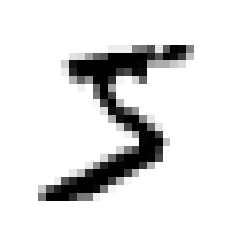

In [21]:
#Grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s imshow()

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
#This looks like a 5, and indeed that’s what the label tells us:

y[0]

'5'

In [6]:
#Note that the label is a string. Most ML algorithms expect numbers, so let’s cast y to integer:

y = y.astype(np.uint8)

In [7]:
#dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
#Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. 
#This “5-detector” will be an example of a binary classifier, 5 and not-5.

y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [9]:
#Let’s create an SGDClassifier and train it on the whole training set:

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
#Now we can use it to detect images of the number 5:

sgd_clf.predict([some_digit])

#The classifier guesses that this image represents a 5 (True). 

array([ True])

## Performance Measures
Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic.

## Measuring Accuracy Using Cross-Validation
A good way to evaluate a model is to use cross-validation

In [11]:
#The following code does roughly the same thing as Scikit-Learn’s cross_val_score() function

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.9502, 0.96565, and 0.96495


0.95035
0.96035
0.9604


In [12]:
#Let’s use the cross_val_score() function to evaluate our SGDClassifier model, using K-fold cross-validation with three folds.

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

#Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? This looks amazing

array([0.95035, 0.96035, 0.9604 ])

### Confusion Matrix

In [13]:
#A much better way to evaluate the performance of a classifier is to look at the confusion matrix.
#To compute the confusion matrix, need to have a set of predictions so that they can be compared to the actual targets.

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [14]:
#Using the confusion_matrix() function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred):

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [15]:
#A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values

y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## Precision
### The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the *precision* of the classifier
### TP/TP+FP

## Recall

### This is the ratio of positive instances that are correctly detected by the classifier
### TP/TP+FN

In [16]:
#Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)


0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

#Now your 5-detector does not look as shiny as it did when you looked at its accuracy. 
#When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

0.6511713705958311

In [18]:
#It is often convenient to combine precision and recall into a single metric called the F1 score

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [24]:
#SkLearn does not let you set the threshold directly, but it gives access to the decision scores that it uses to make predictions.

y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 0
y_some_digit_pred = (y_scores > threshold)